<a href="https://colab.research.google.com/github/Fit-Freak/food-vison/blob/main/Food_Vison_prod_mini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Overview

We are trying to impement an AI Object Detection System that can
1. Identify multiple food items on a plate under different lighting conditions.
2. Create segmentation masks.
3. Predict the food item and estimate portion size.

## 0. Setting Up Platform

Setting up the platform with updated libraries and device agonistic code.

### Installing necessary Packages

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+

import torch
from torch import nn
from packaging import version
import torchvision

required_torch = "1.12.0"
required_torchvision = "0.13.0"

if version.parse(torch.__version__) < version.parse(required_torch) or \
   version.parse(torchvision.__version__) < version.parse(required_torchvision):
    print("[INFO] torch/torchvision versions not as required, installing latest versions.")
    # You can change cu121 to cu118 or cpu as needed
    import os
    os.system("pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121")
    # Reload torch and torchvision to reflect new versions
    import importlib
    importlib.reload(torch)
    importlib.reload(torchvision)

print(f"✅ torch version: {torch.__version__}")
print(f"✅ torchvision version: {torchvision.__version__}")

✅ torch version: 2.8.0+cu126
✅ torchvision version: 0.23.0+cu126


And now let's follow best practice and setup device-agnostic code.

> **Note:** If you're using Google Colab, and you don't have a GPU turned on yet, it's now time to turn one on via Runtime -> Change runtime type -> Hardware accelerator -> GPU. **If you do this, your runtime will likely reset and you'll have to run all of the cells above by going Runtime -> Run before.**

If you are running on a CPU-only machine, please use `torch.load()` with `map_location=torch.device('cpu')` to map your storages to the **CPU**.

### Setting up Device

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
# Setup Number of CPU Workers
import os
num_workers = os.cpu_count()
print(f"✅ Number of CPU Workers: {num_workers}")

✅ Number of CPU Workers: 2


### Set Seeds

In [4]:
import random

seeds = 42

torch.manual_seed(seeds)
torch.cuda.manual_seed(seeds)
random.seed(seeds)

print(f"✅ Set seeds {seeds}")

✅ Set seeds 42


## Downloading Data

In [5]:
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")

#### Download Data

In [6]:
import requests
import zipfile
from pathlib import Path
from tqdm import tqdm

dataset_path = data_path / "foodSeg103"
zip_path = dataset_path / "foodSeg103.zip"

# If the image folder doesn't exist, download it and prepare it...
if dataset_path.is_dir():
    print(f"{dataset_path} directory exists.")
else:
    print(f"Did not find {dataset_path} directory, creating one...")
    dataset_path.mkdir(parents=True, exist_ok=True)

    # Download Dataset with tqdm progress bar
    url = "https://github.com/Fit-Freak/food-vison/raw/refs/heads/main/data/foodSeg103.zip"
    print("⬇️ Downloading foodSeg103 Dataset ...")
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get("content-length", 0))

    with open(zip_path, "wb") as f, tqdm(
        desc="Downloading",
        total=total_size,
        unit="B",
        unit_scale=True,
        unit_divisor=1024,
        ncols=100
    ) as bar:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
                bar.update(len(chunk))

    # Unzip Dataset
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
      print(f"\n📦 Unzipping {zip_path.name} Dataset...")
      for file in tqdm(zip_ref.namelist(), desc="Extracting", ncols=100):
        zip_ref.extract(file, dataset_path)

    print(f"\n✅ Dataset extracted to {dataset_path}")

Did not find data/foodSeg103 directory, creating one...
⬇️ Downloading foodSeg103 Dataset ...


Downloading: 100%|███████████████████████████████████████████████| 634M/634M [00:10<00:00, 63.4MB/s]



📦 Unzipping foodSeg103.zip Dataset...


Extracting: 100%|███████████████████████████████████████████| 14243/14243 [00:07<00:00, 1914.20it/s]


✅ Dataset extracted to data/foodSeg103


#### WalkThrough Directory

In [7]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [8]:
walk_through_dir(dataset_path)

There are 2 directories and 2 images in 'data/foodSeg103'.
There are 2 directories and 0 images in 'data/foodSeg103/train'.
There are 0 directories and 4983 images in 'data/foodSeg103/train/labels'.
There are 0 directories and 4983 images in 'data/foodSeg103/train/images'.
There are 2 directories and 0 images in 'data/foodSeg103/val'.
There are 0 directories and 2135 images in 'data/foodSeg103/val/labels'.
There are 0 directories and 2135 images in 'data/foodSeg103/val/images'.


### Calculate Image Size

In [9]:
from PIL import Image
import numpy as np
from pathlib import Path
from tqdm import tqdm

image_dirs = [dataset_path / "train/images", dataset_path / "val/images"]

#  --- Collect all image paths ---
image_paths = []
for dir_path in image_dirs:
    image_paths.extend(list(dir_path.glob("*.jpg")))

print(f"📸 Found {len(image_paths)} images in total.")

# --- Compute image sizes ---
widths, heights = [], []

for img_path in tqdm(image_paths, desc="Calculating image sizes"):
    try:
        with Image.open(img_path) as img:
            w, h = img.size
            widths.append(w)
            heights.append(h)
    except Exception as e:
        print(f"⚠️ Error reading {img_path.name}: {e}")

# --- Compute averages ---
avg_width = np.mean(widths)
avg_height = np.mean(heights)

print(f"\n✅ Average Image Size:")
print(f"   Width:  {avg_width:.2f} px")
print(f"   Height: {avg_height:.2f} px")
print(f"   Aspect Ratio (W/H): {avg_width / avg_height:.2f}")


📸 Found 7118 images in total.


Calculating image sizes: 100%|██████████| 7118/7118 [00:00<00:00, 11149.56it/s]


✅ Average Image Size:
   Width:  713.34 px
   Height: 596.71 px
   Aspect Ratio (W/H): 1.20


### Setup Trainning and Validation Paths

In [10]:
# Setup train and validation paths
train_dir = dataset_path / "train"
train_img_dir = dataset_path / 'train' / 'images'
train_lbl_dir = dataset_path / 'train' / 'labels'
val_dir = dataset_path / "val"
val_img_dir = dataset_path / 'val' / 'images'
val_lbl_dir = dataset_path / 'val' / 'labels'


train_dir, train_img_dir, train_lbl_dir, val_dir, val_img_dir, val_lbl_dir

(PosixPath('data/foodSeg103/train'),
 PosixPath('data/foodSeg103/train/images'),
 PosixPath('data/foodSeg103/train/labels'),
 PosixPath('data/foodSeg103/val'),
 PosixPath('data/foodSeg103/val/images'),
 PosixPath('data/foodSeg103/val/labels'))

### Display a Random Image

In [11]:
import random

def get_random_image_sample(train_img_dir, val_img_dir, seed=42):
    """
    Pick a random image path from the training or validation image directories.

    Args:
        train_img_dir (Path): Path to the training images directory.
        val_img_dir (Path): Path to the validation images directory.
        seed (int): Random seed for reproducibility.

    Returns:
        tuple[Path, Path | None]: (image_path, corresponding_label_path or None)
    """
    random.seed(seed)
    image_path_list = list(train_img_dir.glob("**/*.jpg")) + list(val_img_dir.glob("**/*.jpg"))

    if not image_path_list:
        raise FileNotFoundError("❌ No images found in the specified directories.")

    # Pick a random image
    random_image_path = random.choice(image_path_list)

    # Build labels path (for segmentation)
    label_path = (
        Path(str(random_image_path).replace("images", "labels"))
        .with_suffix(".png")
    )

    return random_image_path, label_path if label_path.exists() else None

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

def visualize_image_with_mask(img_path, lbl_path=None, alpha=0.5):
    """
    Visualize an image, its mask, and the overlay (combined) image side by side.

    Args:
        img_path (Path): Path to the RGB image file.
        lbl_path (Path, optional): Path to the mask file.
        alpha (float, optional): Transparency level for the mask overlay (0.0–1.0).
    """
    # --- Load the RGB image ---
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # --- Load the mask ---
    mask = None
    if lbl_path and Path(lbl_path).exists():
        mask = np.array(Image.open(lbl_path))

        # Normalize to binary mask if needed
        if mask.max() > 1:
            mask = (mask > 0).astype(np.uint8)

        # Create color mask
        color_mask = np.zeros_like(img)
        color_mask[mask == 1] = [255, 0, 0]  # red

        # Blend the image and mask
        blended = cv2.addWeighted(img, 1 - alpha, color_mask, alpha, 0)
    else:
        blended = img

    # --- Create subplot ---
    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis("off")

    # Mask
    plt.subplot(1, 3, 2)
    if mask is not None:
        plt.imshow(mask, cmap="gray")
        plt.title("Segmentation Mask")
    else:
        plt.text(0.5, 0.5, "No mask available", ha="center", va="center", fontsize=12)
        plt.title("Segmentation Mask")
    plt.axis("off")

    # Combined overlay
    plt.subplot(1, 3, 3)
    plt.imshow(blended)
    plt.title("Overlay (Image + Mask)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    # --- Metadata ---
    print(f"🖼️ Image Path: {img_path}")
    print(f"🎭 Mask Path: {lbl_path if lbl_path and Path(lbl_path).exists() else 'No mask found'}")
    if mask is not None:
        print(f"✅ Mask Coverage: {mask.sum()} pixels ({mask.mean()*100:.2f}% of image)")

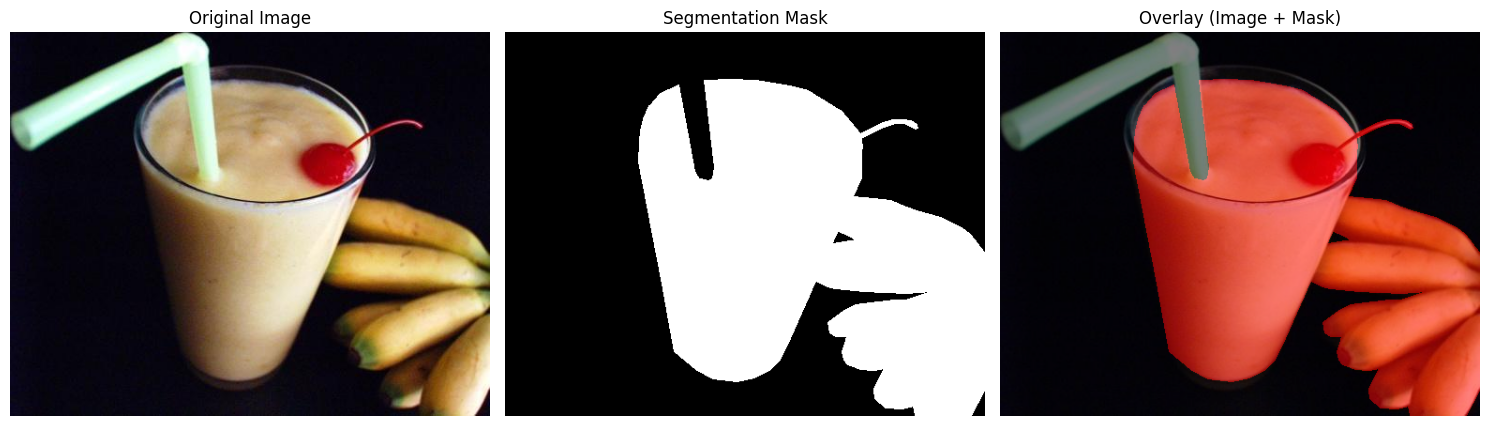

🖼️ Image Path: data/foodSeg103/val/images/392.jpg
🎭 Mask Path: data/foodSeg103/val/labels/392.png
✅ Mask Coverage: 86135 pixels (41.03% of image)


In [13]:
# Pick a random image
img_path, lbl_path = get_random_image_sample(train_img_dir, val_img_dir, seeds)
# Visualize it
visualize_image_with_mask(img_path, lbl_path)

# Generate Mask of Food Items

We implement a **two-model pipeline** combining:

1. **[Segment Anything Model (SAM)](https://segment-anything.com/)** by **Meta AI** — a universal segmentation model that can identify any object in an image.
2. **[CLIP](https://openai.com/research/clip)** by **OpenAI** — a vision-language model that connects images and text in a shared embedding space.

---

### 🧠 Overview

**SAM** is a powerful foundation model designed to **segment any object in any image** with zero or minimal additional training.
It generalizes remarkably well to unseen objects, making it ideal for **zero-shot segmentation** tasks.

By combining SAM with **CLIP**, we can both *segment* and *classify* specific regions — such as isolating **food items** from complex scenes.
This enables semantic filtering, where only relevant masks (e.g., “bread”, “butter”, “plate”, “egg”) are retained for further processing.

---

### 💡 Step-by-Step Summary

| Step  | Description                                                                                                                                    |
| ----- | ---------------------------------------------------------------------------------------------------------------------------------------------- |
| **1** | Use SAM to generate segmentation masks for all detectable objects in the image.                                                                |
| **2** | Crop or extract the region corresponding to each mask.                                                                                         |
| **3** | Encode each region with **CLIP** and compare its image embedding with CLIP text embeddings (e.g., *“food”*, *“bread”*, *“butter”*, *“plate”*). |
| **4** | Keep only the masks with high cosine similarity to food-related text prompts.                                                                  |
| **5** | Visualize or export the filtered segmentation result containing only the desired classes.                                                      |

---

### 🔁 Pipeline Diagram

```text
                ┌──────────────────────────────────────────────────────┐
                │                      Input Image                     │
                └───────────────┬──────────────────────────────────────┘
                                │
                                ▼
                ┌──────────────────────────────────────────────────────┐
                │                   Segment Anything (SAM)             │
                │     → Generates object masks for every region        │
                └───────────────┬──────────────────────────────────────┘
                                │
                                ▼
                ┌──────────────────────────────────────────────────────┐
                │       Crop & Extract Image Regions per Mask          │
                └───────────────┬──────────────────────────────────────┘
                                │
                                ▼
                ┌──────────────────────────────────────────────────────┐
                │               OpenAI CLIP Model                      │
                │   → Encode cropped images and text prompts           │
                │   → Compute similarity scores                        │
                └───────────────┬──────────────────────────────────────┘
                                │
                                ▼
                ┌──────────────────────────────────────────────────────┐
                │         Filter Masks by High Similarity              │
                │  (e.g., “food”, “bread”, “butter”, “jam”, “egg”)     │
                └───────────────┬──────────────────────────────────────┘
                                │
                                ▼
                ┌──────────────────────────────────────────────────────┐
                │           Visualize / Export Food Masks              │
                │   → Combined filtered segmentation output            │
                └──────────────────────────────────────────────────────┘
```

---

### 🎯 Result

After combining **SAM** + **CLIP**, we obtain segmentation masks **filtered by semantic meaning** —
ensuring only **food-related objects** remain in the final output, improving accuracy and interpretability for downstream analysis (e.g., portion estimation, food classification, calorie tracking).


In [14]:
from pathlib import Path

# Setup path to models folder
model_path = Path("model/")
model_path.mkdir(parents=True, exist_ok=True)

## Download SAM Model Checkpoint

In [15]:
import requests
from pathlib import Path
from tqdm import tqdm

# Define paths
model_type = "vit_h"
checkpoint_name = f"sam_{model_type}_4b8939.pth"
checkpoint_path = model_path / checkpoint_name

# Download only if not already present
if checkpoint_path.exists():
    print(f"✅ Checkpoint already exists: {checkpoint_path}")
else:
    url = f"https://dl.fbaipublicfiles.com/segment_anything/{checkpoint_name}"
    print(f"⬇️ Downloading {checkpoint_name} ...")

    response = requests.get(url, stream=True)
    total_size = int(response.headers.get("content-length", 0))

    # Write with tqdm progress bar
    with open(checkpoint_path, "wb") as f, tqdm(
        desc="Downloading SAM checkpoint",
        total=total_size,
        unit="B",
        unit_scale=True,
        unit_divisor=1024,
        ncols=100
    ) as bar:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
                bar.update(len(chunk))

    print(f"\n✅ Download complete: {checkpoint_path}")

⬇️ Downloading sam_vit_h_4b8939.pth ...



✅ Download complete: model/sam_vit_h_4b8939.pth


## Load Models

In [17]:
import os
os.system("pip install git+https://github.com/facebookresearch/segment-anything.git")
print("🆗 Installed SAM")
os.system("pip install regex ftfy")
os.system("pip install git+https://github.com/openai/CLIP.git")
print("🆗 Installed CLIP")

🆗 Installed SAM
🆗 Installed CLIP


### Load SAM Model

In [18]:
from segment_anything import sam_model_registry

sam = sam_model_registry[model_type](checkpoint=checkpoint_path).to(device=device)
print(f"✅ SAM Model {model_type} is loaded from {checkpoint_path} to device {device}")

✅ SAM Model vit_h is loaded from model/sam_vit_h_4b8939.pth to device cpu


### Load CLIP Model

In [19]:
import clip

clip.available_models()


['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [20]:
clip_model, preprocess = clip.load("ViT-B/32", device=device, jit=False) # jit reffers to Just in time to download the latest model
print(f"✅ CLIP Model is loaded to device {device}")

100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 53.5MiB/s]


✅ CLIP Model is loaded to device cpu


## Get an Image

### Get a Random Image Sample

In [23]:
img_path, _ = get_random_image_sample(train_img_dir, val_img_dir, seeds)
img_path

PosixPath('data/foodSeg103/val/images/392.jpg')

### Load The Image

Loaded Image data/foodSeg103/val/images/392.jpg


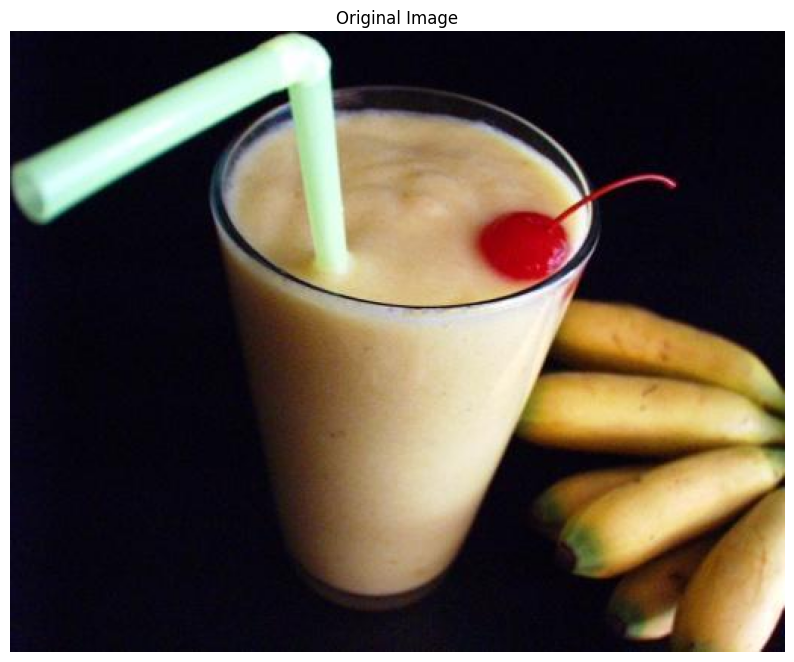

In [26]:
import cv2
import matplotlib.pyplot as plt

# --- Load the RGB image ---
img = cv2.imread(str(img_path))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(f"Loaded Image {img_path}")

# --- Visualize Image ---
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis("off")
plt.show()

## Generate Image Masks

To run automatic mask genertation we need to provide a SAM Model to the `SamAutomaticMaskGenerator` class.

In [ ]:
from segment_anything import SamAutomaticMaskGenerator

mask_gen = SamAutomaticMaskGenerator(
    model=sam,
)
print(f"✅ SAM Mask Generator is loaded to device {device}")

print("Generating Image Mask ...")
masks = mask_gen.generate(img_rgb)

print(f"Generated {len(masks)} masks")

✅ SAM Mask Generator is loaded to device cpu
Generating Image Mask ...


### Define Propmpts

In [ ]:
# --- Define your food-related text prompts ---
food_prompts = [
    "pizza", "burger", "sandwich", "pasta", "rice", "salad",
    "egg", "chicken", "fish", "bread", "dessert", "cake"
]
text_tokens = clip.tokenize(food_prompts).to(device)

### Analyze each mask with CLIP

In [ ]:
# import numpy as np

# def filter_masks(masks,
#                           iou_threshold=0.7,
#                           min_area_ratio=0.001,
#                           min_stability_score=0.85,
#                           min_pred_iou=0.85):
#     """
#     Advanced filtering of SAM masks based on multiple quality criteria.
#     Keeps only high-quality, stable, and unique masks.
#     """
#     if not masks:
#         return []

#     # Sort masks by predicted IoU descending (higher = better)
#     masks = sorted(masks, key=lambda m: m["predicted_iou"], reverse=True)
#     filtered = []
#     image_area = masks[0]["segmentation"].shape[0] * masks[0]["segmentation"].shape[1]

#     for m in masks:
#         # Basic quality thresholds
#         if (m["area"] / image_area) < min_area_ratio:
#             continue
#         if m.get("stability_score", 1.0) < min_stability_score:
#             continue
#         if m.get("predicted_iou", 1.0) < min_pred_iou:
#             continue

#         # IoU overlap suppression
#         keep = True
#         for f in filtered:
#             inter = np.logical_and(m["segmentation"], f["segmentation"]).sum()
#             union = np.logical_or(m["segmentation"], f["segmentation"]).sum()
#             iou = inter / union
#             if iou > iou_threshold:
#                 keep = False
#                 break
#         if keep:
#             filtered.append(m)

#     return filtered

In [ ]:
food_masks = []
for m in masks:
    mask = m["segmentation"]
    x, y, w, h = cv2.boundingRect(mask.astype(np.uint8))
    crop = img_rgb[y:y+h, x:x+w]
    crop_pil = Image.fromarray(crop)
    crop_input = preprocess(crop_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features = clip_model.encode_image(crop_input)
        text_features = clip_model.encode_text(text_tokens)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        best_idx = similarity[0].argmax().item()
        confidence = similarity[0, best_idx].item()

    if confidence > 0.2:  # threshold to keep only relevant food masks
        m["label"] = food_prompts[best_idx]
        m["confidence"] = confidence
        food_masks.append(m)

print(f"Filtered {len(food_masks)} food-related masks")

### Visualize Result with Supervison

In [ ]:
import os

os.system("pip install supervision")

In [ ]:
import supervision as sv

# Create the mask annotator (color by index)
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

# Convert SAM result into Supervision detections
filtered_detections = sv.Detections.from_sam(sam_result=filtered_masks)
unfiltered_detections = sv.Detections.from_sam(sam_result=mask_result)

print("Annotating Image...")
annotated_image_mask_filtered = mask_annotator.annotate(
    scene=img.copy(),
    detections=filtered_detections
)

annotated_image_mask_unfiltered = mask_annotator.annotate(
    scene=img.copy(),
    detections=unfiltered_detections
)


# Plot the result
sv.plot_images_grid(
    images=[img, annotated_image_mask_unfiltered, annotated_image_mask_filtered],
    grid_size=(1, 3),
    titles=["Original Image", "UnFiltered Segmented Image Mask", "Filtered Segmented Image Mask"],
    size=(20, 10)
)
